Importing:
Importing all the necessary libraries 

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely import geometry
from collections import Counter
import os
import json
import pandas as pd
import shapely.geometry
import geopandas as gpd
import geopandas_osm.osm
import cv2
import pickle
from rasterio.tools.mask import mask
import seaborn as sns
import random
from rasterio.merge import merge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
from sklearn.externals import joblib
from sklearn.metrics import mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score

%matplotlib inline

## load npy files into dataframes

Each stacked image contains complete band information from the satellite imagery, including both pan-sharpened and non-pan-sharpened versions. The accompanying masks consist of binary values (0s and 1s) that delineate areas with damaged buildings. The set of four images/masks corresponds to distinct regions within the Philippines for which we possess satellite imagery data.

In [3]:
stacked_image1 = np.load('stacked_imgs_masks/stacked_image1.npy')
stacked_image2 = np.load('stacked_imgs_masks/stacked_image2.npy')
stacked_image3 = np.load('stacked_imgs_masks/stacked_image3.npy')
stacked_image4 = np.load('stacked_imgs_masks/stacked_image4.npy')
stacked_image5 = np.load('stacked_imgs_masks/stacked_image5.npy')

mask1 = np.load('stacked_imgs_masks/mask1.npy')
mask2 = np.load('stacked_imgs_masks/mask2.npy')
mask3 = np.load('stacked_imgs_masks/mask3.npy')
mask4 = np.load('stacked_imgs_masks/mask4.npy')
mask5 = np.load('stacked_imgs_masks/mask5.npy')

The function `to_df` takes two inputs: `stacked_image`, a 3D array where images are stacked layer-wise, and `mask`, which is an array representing some form of classification or result for each pixel in `stacked_image`. The function first creates a DataFrame from the flattened values of the second layer of `stacked_image`. Then, it iterates over the remaining layers (starting from the second), flattening each one and appending these as new columns to the DataFrame. After looping through all the layers, it adds a new column `ground_truth` containing the flattened `mask` data. The DataFrame columns are named systematically based on their band and image type, such as `b1_pre`, `b1_post`, and so forth, ending with `ground_truth` which holds the mask information. The function finally returns this DataFrame, which now organizes all the pixel values from the input data in a tabular format, with each row representing a pixel and each column representing different image attributes and the mask classification.

In [4]:
def to_df(stacked_image, mask):
    
    df = pd.DataFrame(stacked_image[:, :, 1].flatten())

    for i in range(1, stacked_image.shape[2]):
        df1 = pd.DataFrame(stacked_image[:, :, i].flatten())
        df = pd.concat([df, df1], axis = 1)
    
    df['ground_truth'] = mask.flatten()
    
    df.columns = ['b1_pre', 'b2_pre', 'b3_pre', 'b4_pre', 'b5_pre', 'b6_pre', 'b7_pre',
       'b8_pre', 'b9_pre', 'b10_pre', 'b11_pre', 'r_pre', 'g_pre', 'b_pre', 'b1_post', 
        'b2_post', 'b3_post', 'b4_post', 'b5_post', 'b6_post', 'b7_post', 'b8_post',
       'b9_post', 'b10_post', 'b11_post', 'r_post', 'g_post', 'b_post',
        'b1_sub', 'b2_sub', 'b3_sub', 'b4_sub', 'b5_sub', 'b6_sub', 'b7_sub', 'b8_sub', 
        'b9_sub', 'b10_sub', 'b11_sub', 'r_sub', 'g_sub', 'b_sub', 'ground_truth']
    
    return df
    

In [5]:
df1 = to_df(stacked_image1, mask1)
df2 = to_df(stacked_image2, mask2)
df3 = to_df(stacked_image3, mask3)
df4 = to_df(stacked_image4, mask4)

## random forest (balanced samples)

**Train on top half, predict on bottom**

Take bottom 50% of three images (1, 2, 4) as test set. Train on balanced sample from the top half of the same three images.

creating df from three images

In [6]:
full_df = pd.concat([df1, df2, df4]).reset_index().drop('index', axis = 1)

In [7]:
df1.shape

(153600, 43)

In [8]:
df2.shape

(491520, 43)

In [9]:
df3.shape

(135168, 43)

take bottom 50 percent of each image for test set

In [11]:
a = round(df1.shape[0]*.5)
b = df1.shape[0]
c = df1.shape[0] + round(df2.shape[0]*.5)
d = df1.shape[0] + df2.shape[0]
e = df1.shape[0] + df2.shape[0] + round(df3.shape[0]*.5)
f = df1.shape[0] + df2.shape[0] + df3.shape[0]

In [12]:
print(a, b, c, d, e, f)

76800 153600 399360 645120 712704 780288


In [13]:
test_df = pd.concat([full_df.iloc[a:b, :], full_df.iloc[c:d, :], full_df.iloc[e:f, :]])

remainder is top half of three images

In [14]:
remainder = pd.concat([full_df.iloc[:a, :], full_df.iloc[b:c, :], full_df.iloc[d:e, :]])

In [15]:
test_df.ground_truth.value_counts()

0    317204
1     23788
Name: ground_truth, dtype: int64

In [22]:
remainder.ground_truth.value_counts()

0    369631
1     20513
Name: ground_truth, dtype: int64

 create balanced sample from top halves (remainder)
 zero_indices are rows where ground truth is 0 (no damage)

In [23]:
zero_indices = remainder[remainder.ground_truth == 0].index
# select equal number of rows where ground truth == 1 and ground truth == 0
random_indices = np.random.choice(zero_indices, remainder.ground_truth.value_counts()[1], replace=False)

zero_sample = remainder.loc[random_indices]
nonzero_sample = remainder[remainder.ground_truth == 1]

In [25]:
balanced_df = pd.concat([zero_sample, nonzero_sample], axis = 0)

In [26]:
balanced_df.head()

,b1_pre,b2_pre,b3_pre,b4_pre,b5_pre,b6_pre,b7_pre,b8_pre,b9_pre,b10_pre,...,b6_sub,b7_sub,b8_sub,b9_sub,b10_sub,b11_sub,r_sub,g_sub,b_sub,ground_truth
17799,0.092719,0.092719,0.125805,0.269536,0.220621,0.145741,0.081321,0.073816,0.042037,0.022545,...,0.449299,0.456859,0.480292,0.571733,0.663749,0.501404,0.207566,0.768457,0.749378,0
240287,0.374854,0.374854,0.420147,0.576169,0.569915,0.538371,0.360474,0.109501,0.091218,0.107413,...,0.291789,0.390699,0.599886,0.482930,0.450465,0.333402,0.247002,0.519198,0.593609,0
221864,0.169249,0.169249,0.282888,0.580683,0.541624,0.343099,0.228587,0.084019,0.096479,0.130021,...,0.309954,0.393645,0.592509,0.488948,0.473180,0.333123,0.250540,0.525543,0.616247,0
230567,0.251853,0.251853,0.292980,0.477061,0.432320,0.393482,0.218688,0.676682,0.380413,0.248617,...,0.297842,0.372623,0.608358,0.508906,0.479622,0.326033,0.308186,0.468965,0.549818,0
311645,0.136540,0.136540,0.233701,0.530442,0.477484,0.295372,0.195344,0.067734,0.061146,0.083602,...,0.299813,0.368815,0.577420,0.478306,0.458603,0.325999,0.256245,0.551006,0.633538,0


In [27]:
balanced_df.shape

(41026, 43)

In [28]:
test_df.shape

(340992, 43)

In [29]:
X_train = balanced_df.iloc[:, :-1]
y_train = balanced_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [31]:
sns.set_style("whitegrid", {'axes.grid' : False})

             precision    recall  f1-score   support

          0       0.97      0.92      0.95    317204
          1       0.37      0.62      0.47     23788

avg / total       0.93      0.90      0.91    340992

Model: Random Forest Classifier
AUC: 0.91219776062



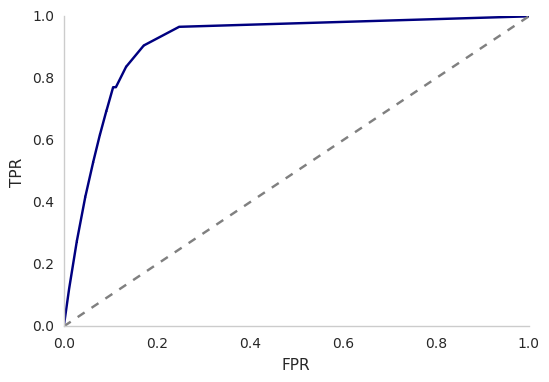

In [33]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print('Model: Random Forest Classifier')
print('AUC: ' + str(roc_auc))
print("")

plt.plot(fpr, tpr, color = 'navy')
plt.plot([0,1],[0,1], '--', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.title('Random Forest ROC');
sns.despine()

In [72]:
# create helper function that allows us to set the threshold for the classification
def threshold_wrapper(proba_list, threshold):
    output_list = []
    for proba in proba_list:
        if proba >= threshold:
            output_list.append(1)
        else:
            output_list.append(0)
    return output_list

In [73]:
y_pred = threshold_wrapper(y_proba, .9)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96    360687
          1       0.46      0.32      0.38     29457

avg / total       0.91      0.92      0.91    390144

0.121776718873


In [74]:
y_pred = threshold_wrapper(y_proba, .92)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.99      0.96    360687
          1       0.50      0.15      0.23     29457

avg / total       0.90      0.92      0.90    390144

0.0555810387498


In [48]:
# save model
joblib.dump(rf, 'best_rf.pkl') 

['best_rf.pkl']

In [49]:
# explore feature importances
sorted_features = sorted(zip(X_train.columns,rf.feature_importances_), key = lambda x: x[1], reverse = True)
for feature in sorted_features:
       print(feature)

('b11_sub', 0.1122234030259186)
('b6_sub', 0.1118456385037619)
('b1_sub', 0.078080161549225341)
('b3_sub', 0.057561763976787562)
('b5_sub', 0.053343263794707121)
('b4_pre', 0.052308733735946578)
('b3_post', 0.046776702649337407)
('b8_post', 0.038891855962687231)
('b11_pre', 0.0351885904797564)
('b1_post', 0.034137464148296451)
('b8_pre', 0.03330059856860422)
('g_pre', 0.025562307440889009)
('b10_sub', 0.02276053601699642)
('b10_post', 0.020159073099823184)
('b10_pre', 0.019509793410883491)
('b8_sub', 0.019198840308527882)
('b_post', 0.014648795194358025)
('g_post', 0.01339358779954029)
('r_post', 0.012917566340539352)
('b2_post', 0.012519067272294907)
('b4_post', 0.012292007481920244)
('b11_post', 0.011975224660306429)
('b9_pre', 0.011971970906296731)
('b4_sub', 0.010868247629840223)
('b9_sub', 0.010774885329328302)
('b5_post', 0.0106904197858814)
('b6_pre', 0.010216479639409002)
('b9_post', 0.0097533404483684857)
('b_pre', 0.0087065861240561999)
('g_sub', 0.0086511215333867006)
('b7_p

**Train on three images, predict on new image**

Create balanced dataframe for training from images 1, 2, 4. Test on image 3.

In [57]:
remainder = pd.concat([df1, df2, df4], axis = 0).reset_index().drop('index', axis = 1)

In [58]:
remainder.ground_truth.value_counts()

0    686835
1     44301
Name: ground_truth, dtype: int64

In [59]:
zero_indices = remainder[remainder.ground_truth == 0].index
random_indices = np.random.choice(zero_indices, remainder.ground_truth.value_counts()[1], replace=False)
zero_sample = remainder.loc[random_indices]

In [60]:
nonzero_sample = remainder[remainder.ground_truth == 1]

In [61]:
balanced_df = pd.concat([zero_sample, nonzero_sample], axis = 0)

In [62]:
X_train = balanced_df.iloc[:, :-1]
y_train = balanced_df.iloc[:, -1]
X_test = df3.iloc[:, :-1]
y_test = df3.iloc[:, -1]

             precision    recall  f1-score   support

          0       0.94      0.54      0.69    122416
          1       0.14      0.69      0.23     12752

avg / total       0.87      0.55      0.64    135168

Model: Random Forest Classifier
AUC: 0.676731951842



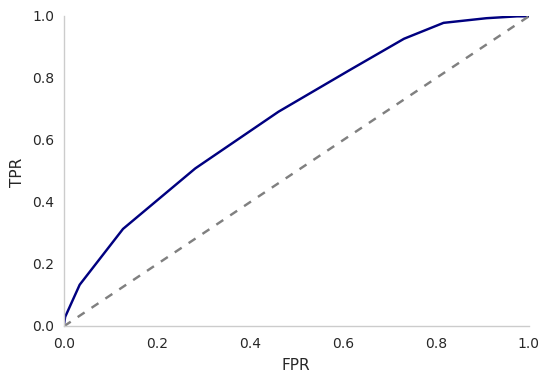

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print('Model: Random Forest Classifier')
print('AUC: ' + str(roc_auc))
print("")

plt.plot(fpr, tpr, color = 'navy')
plt.plot([0,1],[0,1], '--', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.title('Random Forest ROC');
sns.despine()

In [197]:
y_pred = threshold_wrapper(y_proba, .2)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.16      0.27    122416
          1       0.11      0.96      0.19     12752

avg / total       0.89      0.23      0.26    135168

0.015780487503


In [198]:
y_pred = threshold_wrapper(y_proba, .4)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.36      0.52    122416
          1       0.11      0.78      0.20     12752

avg / total       0.86      0.40      0.49    135168

0.00609450181109


In [199]:
y_pred = threshold_wrapper(y_proba, .6)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.71      0.81    122416
          1       0.15      0.50      0.24     12752

avg / total       0.86      0.69      0.75    135168

0.0137401494419


Here is the similar code for Fully Connected Neural Network (FCNN) 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import AUC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(16, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Model: Fully Connected Neural Network\nAUC: {scores[1]}\n')

# Predict classes
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

# Predict probabilities
y_proba = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color = 'navy')
plt.plot([0,1],[0,1], '--', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
sns.despine()


## density map

In [200]:
stacked_image3.shape

(352, 384, 42)

In [201]:
pixel_matrix = np.reshape(y_pred, (352, 384))
# isolating non zero pixel coordinates for plotting
x = np.nonzero(pixel_matrix)[1]
y = np.nonzero(pixel_matrix)[0]
pix_coords = np.vstack((x, y)).T
pix_coords.shape

(41545, 2)

In [202]:
pix_coords

array([[  1,   0],
       [  2,   0],
       [  3,   0],
       ..., 
       [365, 351],
       [376, 351],
       [377, 351]])

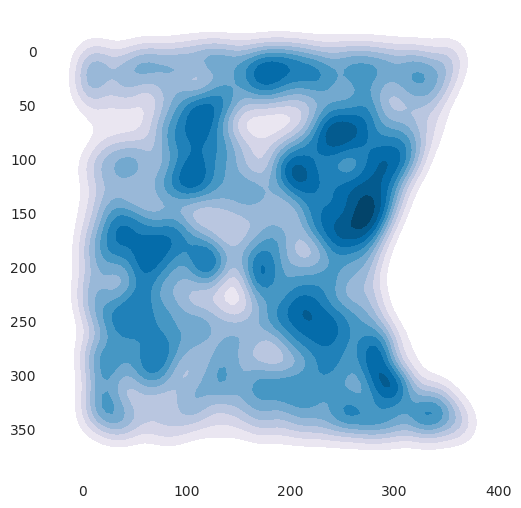

In [203]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.kdeplot(pix_coords, shade = True, cmap = "PuBu")
ax.invert_yaxis()
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
plt.show()

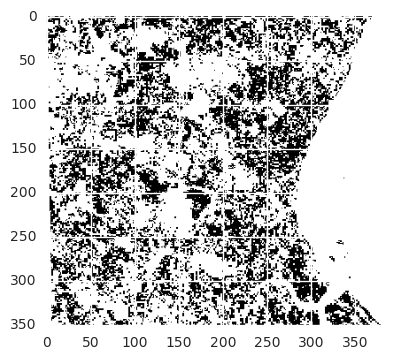

In [204]:
plt.imshow(pixel_matrix)

This code defines a Pix2Pix GAN model that uses a U-Net-like architecture for the generator and a PatchGAN-like architecture for the discriminator. The generator takes an image and generates a new image, and the discriminator takes a pair of images (the original image and the generated image) and determines whether the generated image is real or fake.

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam

def build_generator():
    def conv2d(layer_input, filters, f_size=4):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        u = Conv2DTranspose(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        u = Activation('relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(d0, gf)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)

    # Upsampling
    u1 = deconv2d(d4, d3, gf*4)
    u2 = deconv2d(u1, d2, gf*2)
    u3 = deconv2d(u2, d1, gf)

    u4 = Conv2DTranspose(gf, kernel_size=4, strides=2, padding='same')(u3)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)

def build_discriminator():
    def d_layer(layer_input, filters, f_size=4, normalization=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)

    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([img_A, img_B], validity)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=Adam(0.0002, 0.5))
